# Human protein classification


In [1]:
import numpy as np 
import pandas as pd
from pprint import pprint
import os
root_train_directory = '/kaggle/input/human-protein-atlas-image-classification/train/'
root_test_directory = '/kaggle/input/human-protein-atlas-image-classification/test/'
input_shape=(128,128,4)
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

Let's load the data

In [2]:
train_df = pd.read_csv('/kaggle/input/human-protein-atlas-image-classification/train.csv')
train_df.set_index('Id',inplace=True)
train = train_df.to_dict()['Target']
train_img_names = list(train.keys())

For the training to work, we need to merge all the layer of each image and turn them into rgby images. We'll also resize the images to make training and prediction faster.

In [3]:
SIZE = (128,128)
def get_labels(img):
    return list(map(int, train[img].split(' ')))
# We'll fusion images
def open_multilayer_image(path, test=False):
    fullpath = root_train_directory+path
    if test:
        fullpath = root_test_directory+path
    red = plt.imread(fullpath+"_red.png")
    red = cv2.resize(red, SIZE)
    green = plt.imread(fullpath+"_green.png")
    green = cv2.resize(green, SIZE)
    blue = plt.imread(fullpath+"_blue.png")
    blue = cv2.resize(blue, SIZE)
    yellow = plt.imread(fullpath+"_yellow.png")
    yellow = cv2.resize(yellow, SIZE)
    ni = np.zeros((SIZE[0],SIZE[1],4), 'uint8')
    ni[..., 0] = red*255
    ni[..., 1] = green*255
    ni[..., 2] = blue*255
    ni[..., 3] = yellow*255
    return ni

We can have an idea of what's the date look like by looking at a few samples selected randomly along with their labels.

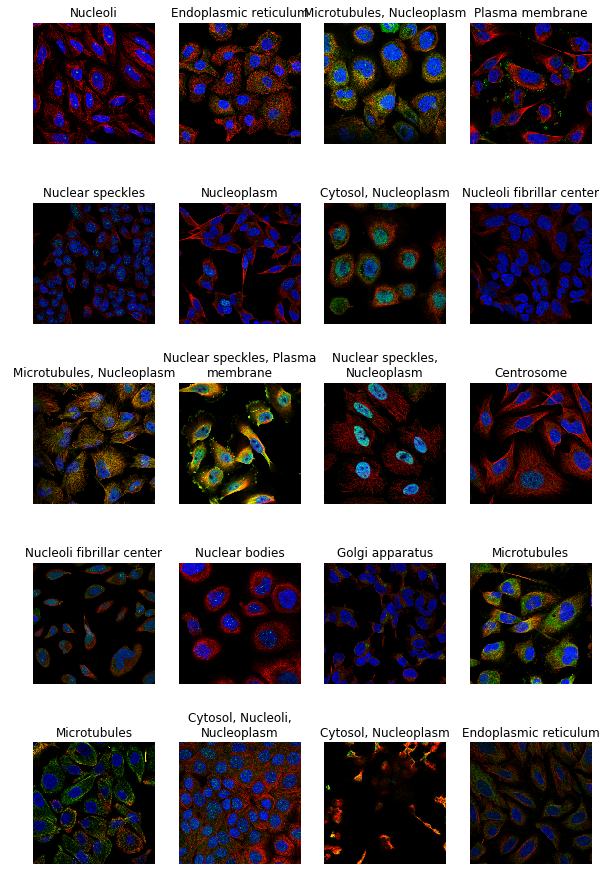

In [4]:
import cv2
import matplotlib.pyplot as plt
from random import randrange
from textwrap import wrap


fig=plt.figure(figsize=(10, 16))

columns = 4
rows = 5
for i in range(1, columns*rows +1):
    num = randrange(len(train_img_names))
    img_name = train_img_names[num]
    img = open_multilayer_image(img_name)
    sub = fig.add_subplot(rows, columns, i)
 
    title = ''
    for label in get_labels(img_name):
        title+=name_label_dict[label]+', '
    sub.set_title("\n".join(wrap(title[:-2],25)))
    plt.axis('off')
    plt.imshow(img[...,:-1])
plt.show();

We need to convert every 0-255 value to a 0-1 real value so that the model can train.

In [5]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint

batch_size = 128
num_classes = len(name_label_dict)
epochs = 60

def preprocess_x(share, train_img_names, test=False):
    x_train = []
    for i in range(0,int(len(train_img_names)*share)):
        x_train.append(open_multilayer_image(train_img_names[i], test))
    x_train = np.array(x_train)
    x_train = x_train.astype('float32')
    x_train /= 255
    return x_train


def preprocess_y(share, train_img_names):
    y_train = []
    for i in range(0,int(len(train_img_names)*share)):
        y_train.append(get_labels(train_img_names[i]))
    y_train = np.array(y_train)

    # convert class vectors to binary class matrices
    y_train_formatted = []
    for y in y_train:
        label = np.zeros(num_classes)
        for j in y:
            label[j]=1
        y_train_formatted.append(label)
    y_train = np.array(y_train_formatted)
    return y_train


x_train  = preprocess_x(0.01, train_img_names)
y_train  = preprocess_y(0.01, train_img_names)

x_test = x_train[int(len(x_train)*0.8):]
x_train = x_train[:int(len(x_train)*0.8)]

y_test = y_train[int(len(y_train)*0.8):]
y_train = y_train[:int(len(y_train)*0.8)]


Using TensorFlow backend.


We use a data generator to be able to train on all the images without need for a hudge amount of RAM.

In [6]:
# Data genetor

import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):

    def __init__(self, list_IDs, image_path,
                 to_fit=True, batch_size=32, dim=SIZE,
                 n_channels=4, n_classes=10, shuffle=True):

        self.list_IDs = list_IDs
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
       
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
       
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
      
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
       
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

       
        for i, ID in enumerate(list_IDs_temp):
        
            X[i,] = self._load_and_preprocess(self.image_path + ID)

        return X

    def _generate_y(self, list_IDs_temp):
       
        y_train = []
        for img_id in list_IDs_temp:
            y_train.append(get_labels(img_id))
        y_train = np.array(y_train)

        y_train_formatted = []
        for y in y_train:
            label = np.zeros(num_classes)
            for j in y:
                label[j]=1
            y_train_formatted.append(label)
        y_train = np.array(y_train_formatted)
        return y_train

    def _load_and_preprocess(self, image_path):
        
        fullpath = image_path
        red = plt.imread(fullpath+"_red.png")
        red = cv2.resize(red, SIZE)
        green = plt.imread(fullpath+"_green.png")
        green = cv2.resize(green, SIZE)
        blue = plt.imread(fullpath+"_blue.png")
        blue = cv2.resize(blue, SIZE)
        yellow = plt.imread(fullpath+"_yellow.png")
        yellow = cv2.resize(yellow, SIZE)
        ni = np.zeros((SIZE[0],SIZE[1],4), 'uint8')
        ni[..., 0] = red*255
        ni[..., 1] = green*255
        ni[..., 2] = blue*255
        ni[..., 3] = yellow*255
        ni = ni.astype('float32')
        ni /= 255
        return ni

In [7]:
import tensorflow as tf
THRESHOLD = 0.05 
def f1(y_true, y_pred):
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                  metrics=['accuracy', f1])
    return model


In [8]:
model = create_model()

image_path = root_train_directory
training_generator = DataGenerator(train_img_names[:int(len(train_img_names)*0.8)], image_path, dim=SIZE,
                 n_channels=4)
validation_generator = DataGenerator(train_img_names[int(len(train_img_names)*0.8):], image_path, dim=SIZE,
                 n_channels=4)

H = model.fit_generator(generator=training_generator, validation_data=validation_generator,
          epochs=epochs,
          verbose=1,
         callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1), ModelCheckpoint
                      (filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)])
model = create_model()
model.load_weights('/tmp/weights.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/60
776/776 [==============================] - 1753s 2s/step - loss: 0.1871 - accuracy: 0.9399 - f1: 0.0990 - val_loss: 0.1584 - val_accuracy: 0.9473 - val_f1: 0.1088

Epoch 00001: val_loss improved from inf to 0.15836, saving model to /tmp/weights.hdf5
Epoch 2/60
776/776 [==============================] - 1672s 2s/step - loss: 0.1640 - accuracy: 0.9472 - f1: 0.1133 - val_loss: 0.1471 - val_accuracy: 0.9478 - val_f1: 0.1219

Epoch 00002: val_loss improved from 0.15836 to 0.14710, saving model to /tmp/weights.hdf5
Epoch 3/60
776/776 [==============================] - 1664s 2s/step - loss: 0.1571 - accuracy: 0.9485 - f1: 0.1238 - val_loss: 0.1624 - val_accuracy: 0.9492 - val_f1: 0.1355

Epoch 00003: val_loss did not improve from 0.14710
Epoch 4/60
776/776 [==============================] - 1674s 2s/step - loss: 0.1509 - accuracy: 0.9495 - f1: 0.1335 - val_loss: 0.1254 - val_accuracy: 0.9496 - val_f1: 0.1442

Epoch 00004: val_loss improved from 0.14710 to 0.12541, saving model to /

Test loss: 0.12840395540960373
Test accuracy: 0.9533409476280212


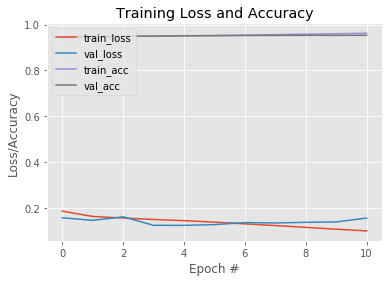

In [9]:
model = create_model()
model.load_weights('/tmp/weights.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.style.use("ggplot")
plt.figure()
N = len(H.history['loss'])
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [10]:
def pred_to_textlabels(pred):
    classes = np.nonzero(pred[0])[0]
    text = ''
    for cl in classes:
        text+=str(name_label_dict[cl])+' '
    return text
    

## Prediction examples
Let's now have a look to a few samples from the validation set to have a more precise idea of how the model b

' Actin filaments, Centrosome, Cytosol,  'was predicted as' Nucleoli Endoplasmic reticulum Plasma membrane Cytosol  '
' Cytosol, Nucleoplasm,  'was predicted as' Nucleoplasm Plasma membrane Cytosol  '
' Actin filaments, Plasma membrane,  'was predicted as' Nucleoli Endoplasmic reticulum Intermediate filaments Plasma membrane Cytosol  '
' Lipid droplets, Nucleoplasm,  'was predicted as' Nucleoplasm Nucleoli Cytosol  '
' Nucleoli,  'was predicted as' Nucleoli Mitochondria  '
' Cell junctions, Nucleoli, Nucleoplasm,  'was predicted as' Nucleoplasm Nucleoli Cytosol  '
' Cytosol,  'was predicted as' Nucleoli Endoplasmic reticulum Cytosol  '
' Nuclear membrane, Nucleoplasm,  'was predicted as' Nucleoplasm  '
' Nuclear bodies,  'was predicted as' Nucleoli  '
' Cell junctions,  'was predicted as' Golgi apparatus  '
' Endoplasmic reticulum,  'was predicted as' Nucleoli Endoplasmic reticulum Intermediate filaments Cytosol  '
' Intermediate filaments,  'was predicted as' Intermediate filaments  '

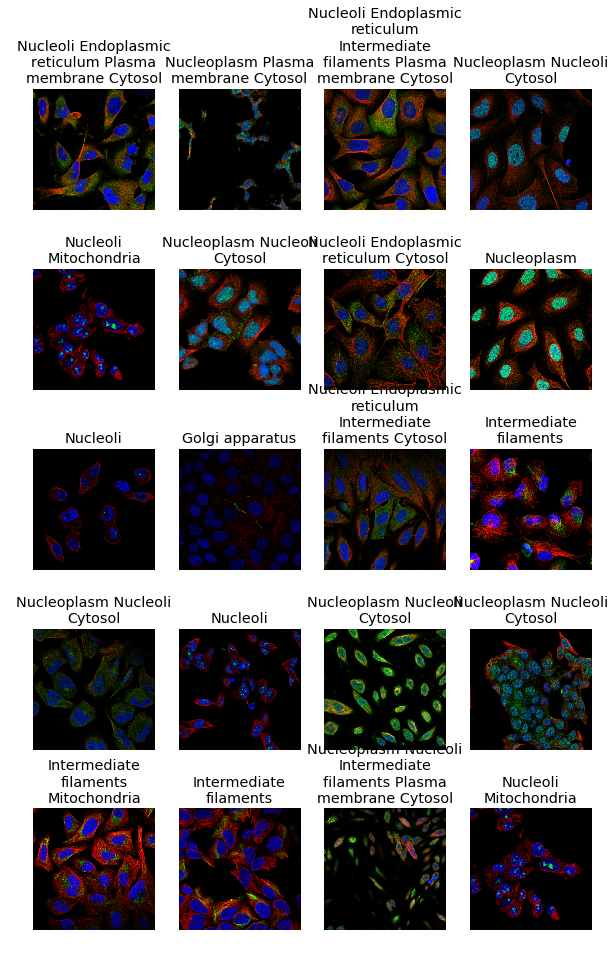

In [11]:
fig=plt.figure(figsize=(10, 16))

columns = 4
rows = 5
for i in range(1, columns*rows +1):
    num = randrange(len(train_img_names))
    num = randrange(1200)
    img_name = train_img_names[num]
    img = open_multilayer_image(img_name)
    img_to_predict = cv2.resize(img, SIZE)
    pred = model.predict(np.array([img_to_predict]))
    title = pred_to_textlabels(pred)
    
    real_label = ''
    for label in get_labels(img_name):
        real_label+=name_label_dict[label]+', '
    print('\'',real_label, '\'was predicted as\'',title,'\'' )
    sub = fig.add_subplot(rows, columns, i)
    sub.set_title("\n".join(wrap(title,20)))
    plt.axis('off')
    plt.imshow(img[...,:-1])
plt.show();